Shopper Spectrum: Segmentation and Recommendations

Step 1 Importing the Libraries and Data loading

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv("online_retail.csv")

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


Data Understanding

In [21]:
# shape of the dataset
print("Shape of dataset:", df.shape)

print("---------------------------------------------")
# dataset info
df.info()
print("---------------------------------------------")
#null values check
print("\nMissing Values:\n", df.isnull().sum())
print("---------------------------------------------")
#check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())
print("---------------------------------------------")
#Summary stats
df.describe()

Shape of dataset: (541909, 8)
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
---------------------------------------------

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
---------------------------------------------

Duplicate Rows: 5268


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Data preprocessing

In [22]:
# take a copy for restoring the originality of the data
df_clean = df.copy()

In [23]:
# Missing rows has been removed with respect to Columns ID
df_clean = df_clean[~df_clean['CustomerID'].isnull()]

In [24]:
# Removin the cancelled orders (InvoiceNo starts with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

In [27]:
# Removing the rows with Quantity <= 0 or UnitPrice <= 0
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

In [28]:
# Reset index after cleaning
df_clean.reset_index(drop=True, inplace=True)

In [29]:
print("Cleaned Dataset Shape:", df_clean.shape)
print("Remaining Nulls:\n", df_clean.isnull().sum())

Cleaned Dataset Shape: (397884, 8)
Remaining Nulls:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [30]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [32]:
# Unique customer count
print(" Unique Customers:", df_clean['CustomerID'].nunique())

 Unique Customers: 4338


EDA

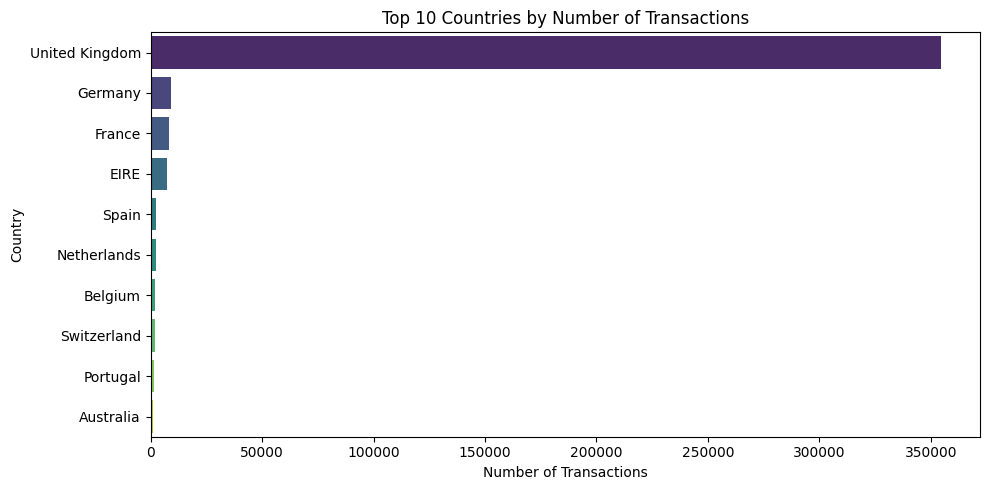

In [33]:
# Top countries by number of transactions
top_countries = df_clean['Country'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

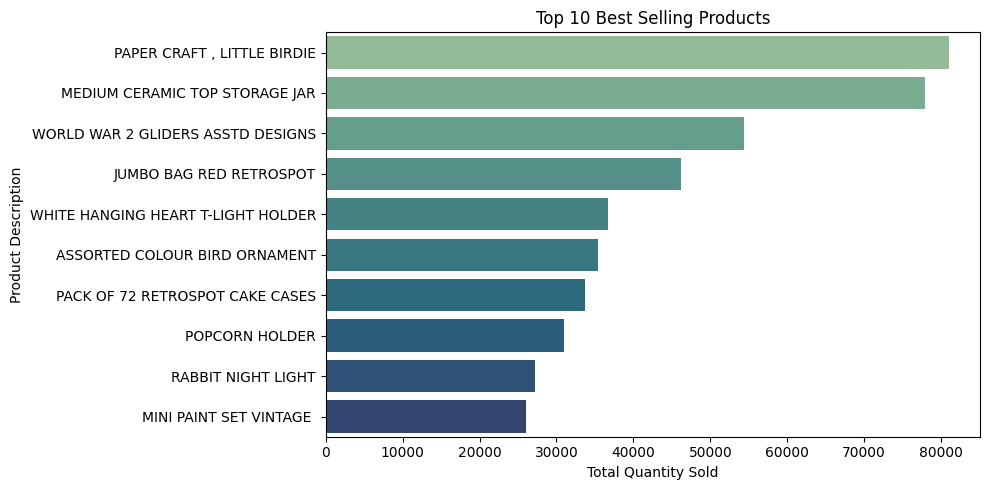

In [34]:
# Top 10 selling products by quantity
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette="crest")
plt.title("Top 10 Best Selling Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()

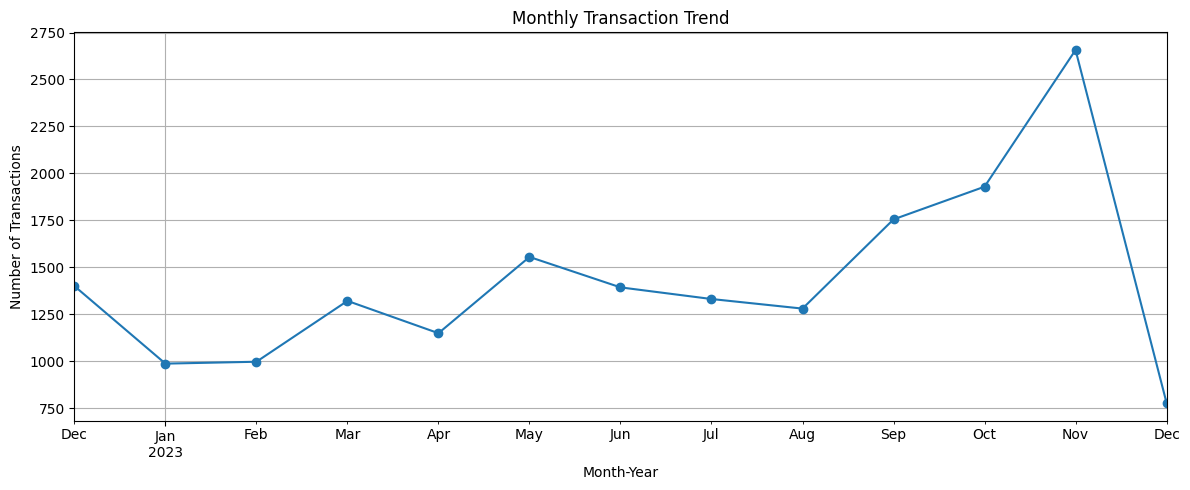

In [35]:
# Converting the InvoiceDate to datetime format
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Extracting the Month-Year
df_clean['MonthYear'] = df_clean['InvoiceDate'].dt.to_period('M')

monthly_sales = df_clean.groupby('MonthYear')['InvoiceNo'].nunique()

plt.figure(figsize=(12,5))
monthly_sales.plot(marker='o')
plt.title("Monthly Transaction Trend")
plt.xlabel("Month-Year")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.tight_layout()
plt.show()

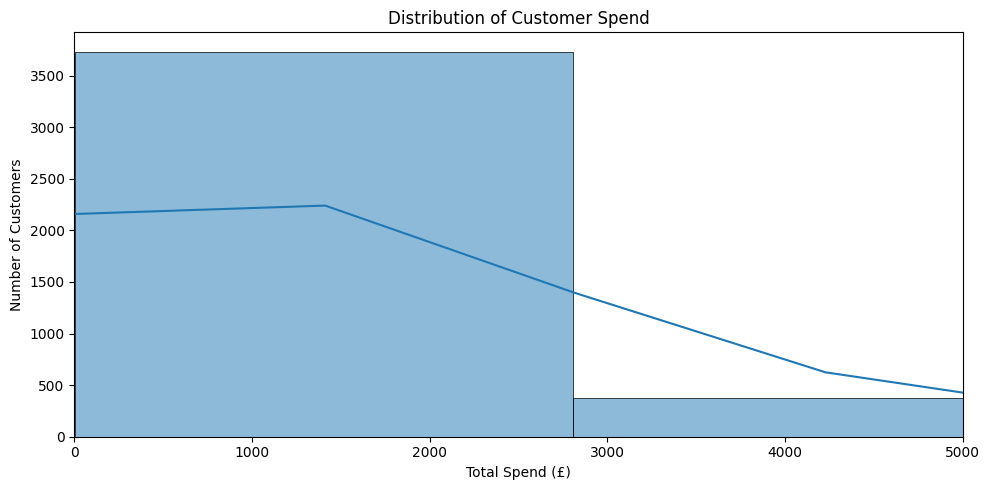

In [38]:
# Calculate Total Price for each row
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Total spend per customer
customer_spend = df_clean.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(10,5))
sns.histplot(customer_spend, bins=100, kde=True)
plt.title("Distribution of Customer Spend")
plt.xlabel("Total Spend (£)")
plt.ylabel("Number of Customers")
plt.xlim(0, 5000)
plt.tight_layout()
plt.show()

RFM Calculation

In [39]:
# here the reference date is taken as 1 day after the last invoice date
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
})

# Renaming the columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']


rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


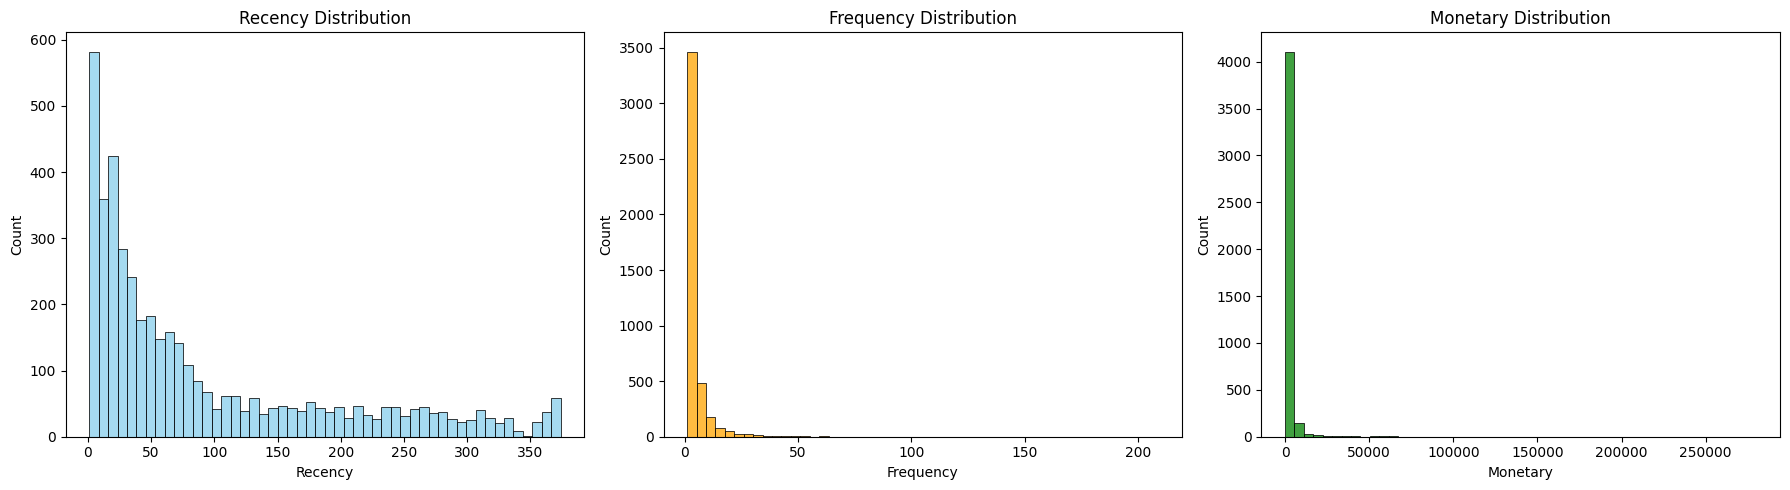

In [40]:
# Distribution plots
fig, ax = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], bins=50, ax=ax[0], color='skyblue')
ax[0].set_title("Recency Distribution")

sns.histplot(rfm['Frequency'], bins=50, ax=ax[1], color='orange')
ax[1].set_title("Frequency Distribution")

sns.histplot(rfm['Monetary'], bins=50, ax=ax[2], color='green')
ax[2].set_title("Monetary Distribution")

plt.tight_layout()
plt.show()

Elbow Method to Find Optimal Clusters (KMeans Prep)

In [42]:
# Standardize RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow method
inertia = []
silhouette = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))

we can clearly see that the "elbow" occurs at K=4, where the rate of decrease in inertia slows down significantly.


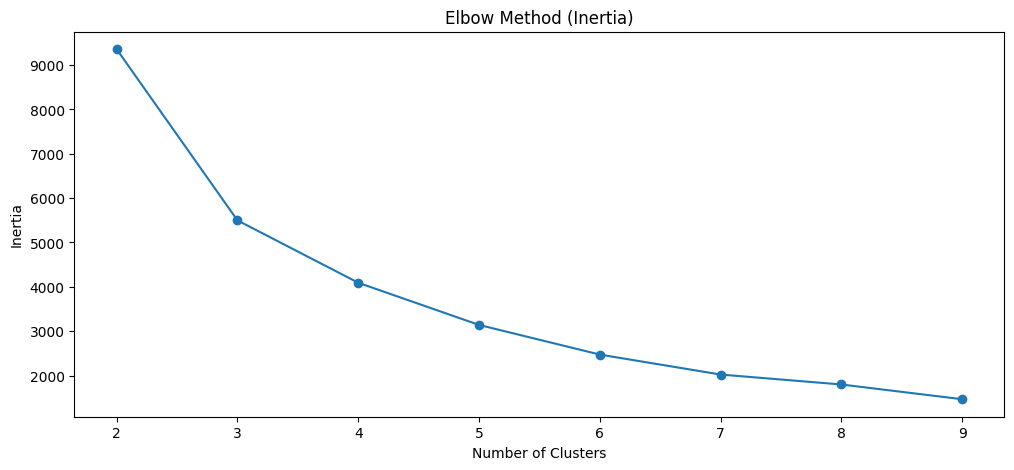

In [43]:
# inertia
plt.figure(figsize=(12,5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

print('we can clearly see that the "elbow" occurs at K=4, where the rate of decrease in inertia slows down significantly.')

Text(0, 0.5, 'Silhouette Score')

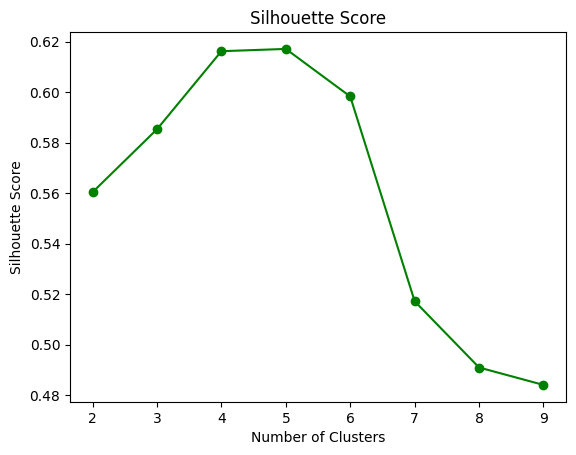

In [44]:
#  silhouette
plt.plot(K, silhouette, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

Clustering & Segment Labeling

In [45]:
# Applying the KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [46]:
# Labeling the Segments (Based on RFM Averages)
# Mean RFM values for each cluster
cluster_profile = rfm.groupby('Cluster').mean().round(1)
cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
0,43.7,3.7,1359.0
1,248.1,1.6,480.6
2,7.4,82.5,127338.3
3,15.5,22.3,12709.1


In [47]:
# Based on manual inspection
cluster_labels = {
    0: 'Regular',
    1: 'At-Risk',
    2: 'High-Value',
    3: 'Occasional'
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

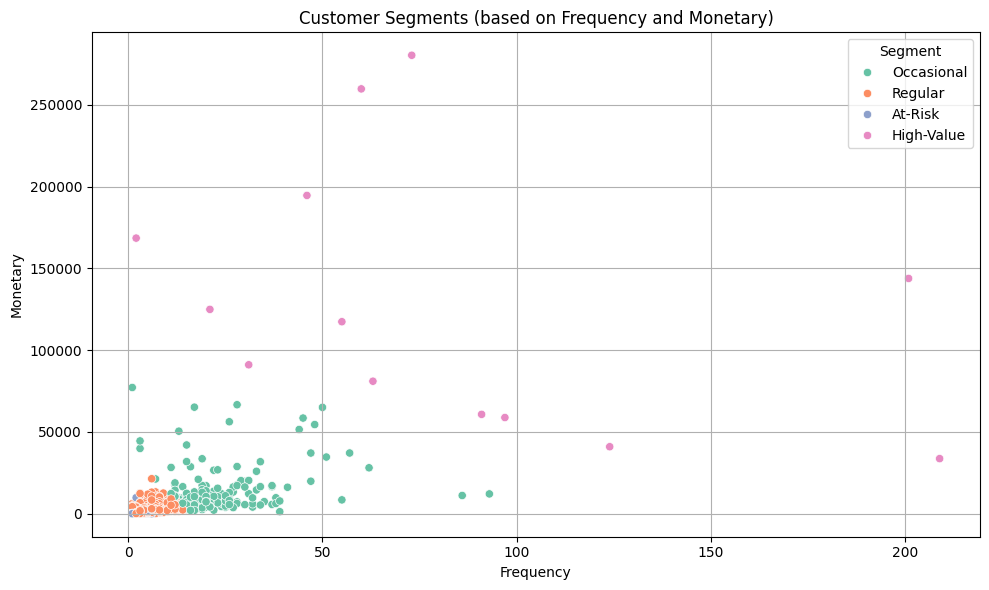

In [48]:
# 2D Scatter Plot: Frequency vs Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='Set2')
plt.title("Customer Segments (based on Frequency and Monetary)")
plt.grid(True)
plt.tight_layout()
plt.show()

Product recommendation System

In [49]:
# Creating a pivot table for customers vs products
user_item_matrix = df_clean.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

In [50]:
# computing the item to item cosine similarity
# we have to Transpose to get item-item similarity (products as rows)
item_similarity = cosine_similarity(user_item_matrix.T)

# Converting to DataFrame for lookup
item_sim_df = pd.DataFrame(item_similarity,
                           index=user_item_matrix.columns,
                           columns=user_item_matrix.columns)

In [51]:
# getting the product descriptions for mapping
product_map = df_clean[['StockCode', 'Description']].drop_duplicates().dropna()
product_map = product_map.groupby('StockCode').first()['Description']

# this function is used for recommendations
def recommend_products(stock_code, top_n=5):
    if stock_code not in item_sim_df:
        return ["Product not found."]

    # to get the top N similar items
    similar_items = item_sim_df[stock_code].sort_values(ascending=False)[1:top_n+1]
    return product_map.loc[similar_items.index].values.tolist()

In [52]:
sample_code = '85123A'  # (White Hanging Heart T-Light Holder)

print("Top 5 similar products:")
for item in recommend_products(sample_code):
    print("-", item)

Top 5 similar products:
- GIN + TONIC DIET METAL SIGN
- RED HANGING HEART T-LIGHT HOLDER
- WASHROOM METAL SIGN
- LAUNDRY 15C METAL SIGN
- GREEN VINTAGE SPOT BEAKER


In [53]:
import pickle

# Save KMeans model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save item similarity matrix
item_sim_df.to_pickle("item_similarity.pkl")

# Save product map
product_map.to_pickle("product_map.pkl")